<div class="alert alert-success">
<h1>Advanced Statistical Inference</h1>
<h2>Assessed Exercise</h2>
</div>

<div class="alert alert-warning">
<h3>Introduction and Instruction</h3>
<br>
In this work you will analyze the MNIST and CIFAR10 datasets available to download from:
<br>
<ul>
<li>http://yann.lecun.com/exdb/mnist/
<li>https://www.cs.toronto.edu/~kriz/cifar.html
</ul>
<br>
Listed below are various exercises to undertake.
</div>

<div class="alert alert-info">
Download the MNIST and CIFAR10 datasets and import them.
</div>

In [24]:
from keras.datasets import mnist, cifar10

(mnist_train_data, mnist_train_label), (mnist_test_data, mnist_test_label) = mnist.load_data()
(cifar10_train_data, cifar10_train_label), (cifar10_test_data, cifar10_test_label) = cifar10.load_data()

<div class="alert alert-info">
Comment on the distribution of class labels and the dimensionality of the input and how these may affect the analysis.
</div>

In [55]:
len(cifar10_test_data)

10000

In [35]:
import os
import sys
import re
import random

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from time import time

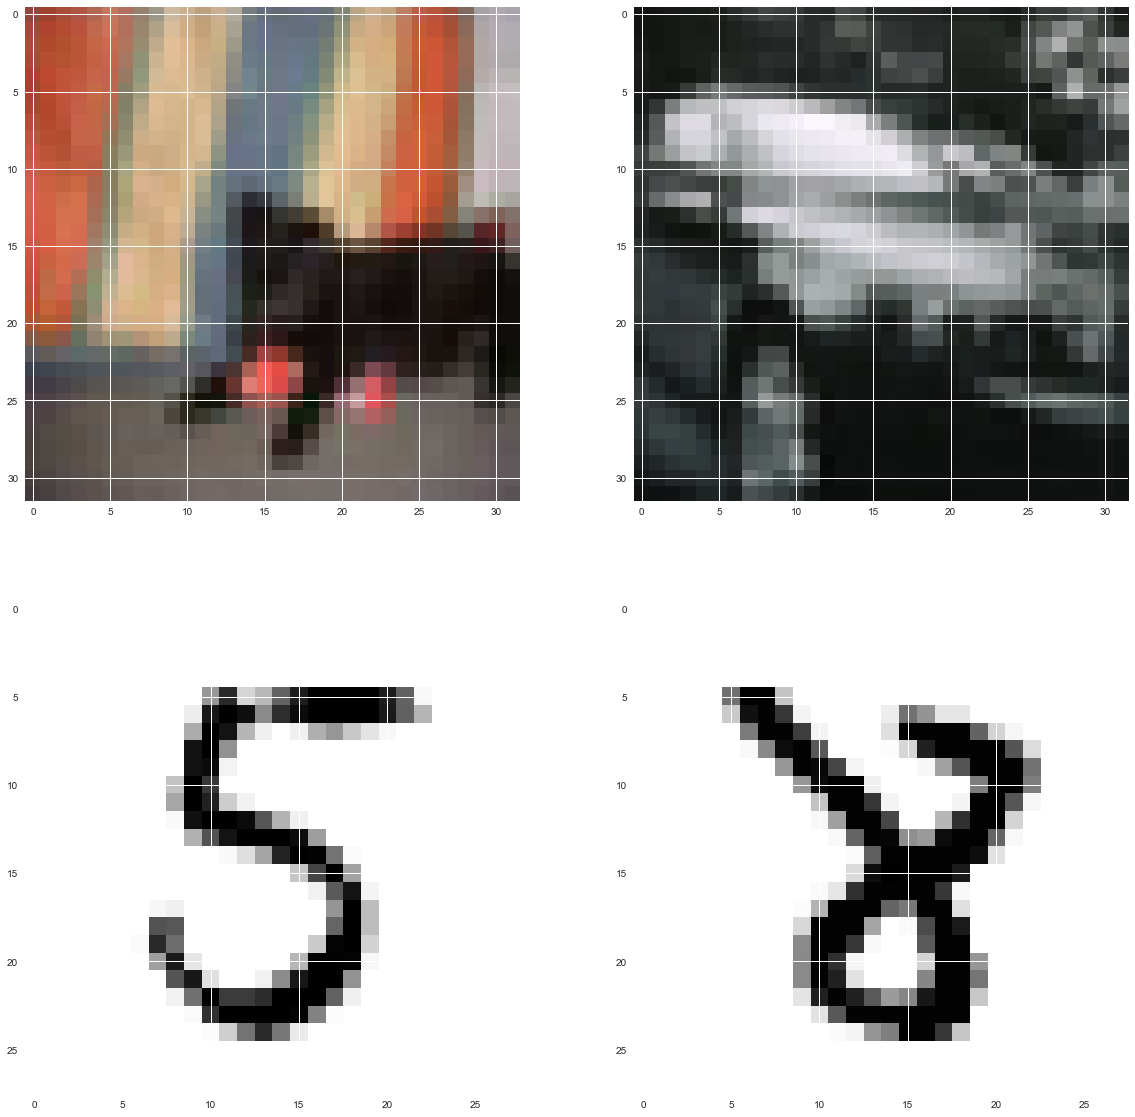

In [68]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(cifar10_test_data[np.random.randint(0, len(cifar10_test_data))])
plt.subplot(222)
plt.imshow(cifar10_test_data[np.random.randint(0, len(cifar10_test_data))])
plt.subplot(223)
plt.imshow(mnist_test_data[np.random.randint(0, len(mnist_test_data))])
plt.subplot(224)
plt.imshow(mnist_test_data[np.random.randint(0, len(mnist_test_data))])
plt.show()

<div class="alert alert-danger">
TODO comment figures, plot distribution of labels
</div>

<div class="alert alert-warning">
<h3>Classification</h3>
</div>

<div class="alert alert-info">
Implement the Naïve Bayes classifier.
</div>